In [1]:
import re
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

import seaborn as sns

from scipy.ndimage.filters import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy

In [3]:
agrochemistry_total = pd.read_csv('ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']


agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]
agrochemistry_main['GPS №'] = agrochemistry_main['GPS №'].astype(int)
agrochemistry_main.drop('повторность', axis = 1, inplace= True)
agrochemistry_main.dropna(axis = 0, inplace= True)

agrochemistry_main['Гумус, %'] = agrochemistry_main['Органический углерод, %'] * 1.724
агрохимия_для_статьи = agrochemistry_main[['GPS №','Тип обработки',"рН солевой вытяжки, ед. рН", "рН водной вытяжки, ед. рН", "Фосфор (подвижная форма), мг/кг", "Калий (подвижная форма), млн-1", "Общий азот, %",'Гумус, %' ]]

In [38]:
плакоры = агрохимия_для_статьи[агрохимия_для_статьи['GPS №'].isin([529, 526])]
тальвеги = агрохимия_для_статьи[агрохимия_для_статьи['GPS №'].isin([584, 527])]

In [39]:
плакоры.groupby('Тип обработки').count()

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,15,15,15,15,15,15,15
ТТ,15,15,15,15,15,15,15


In [40]:
плакоры.groupby('Тип обработки').mean()

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,526,7.345333,8.222,14.827586,305.377905,0.158667,1.766502
ТТ,529,7.224000,8.246,18.243021,262.931607,0.163333,2.275025


In [41]:
плакоры.groupby('Тип обработки').std()

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,0.0,0.087003,0.215645,5.228133,60.407442,0.035024,0.772234
ТТ,0.0,0.179515,0.083905,6.002118,49.559058,0.014960,0.134217


In [42]:
плакоры.groupby('Тип обработки').std() / плакоры.groupby('Тип обработки').mean() * 100

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,0.0,1.184466,2.622783,35.259500,19.781209,22.073824,43.715447
ТТ,0.0,2.484984,1.017520,32.900897,18.848650,9.159346,5.899594


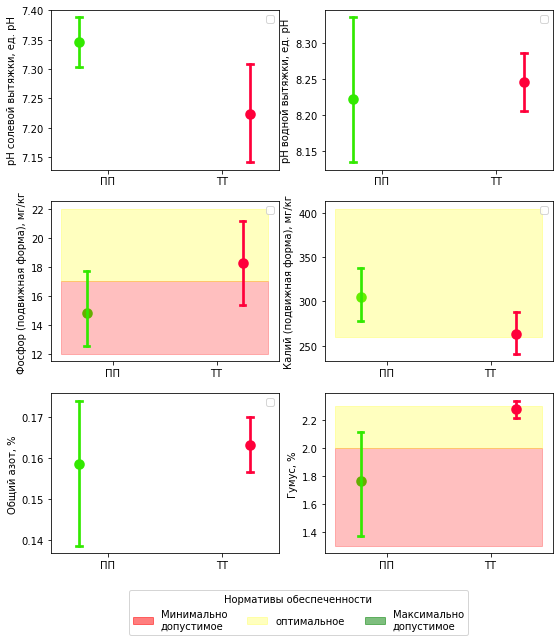

In [43]:
agrochem_prop = [
    "рН солевой вытяжки, ед. рН",
    "рН водной вытяжки, ед. рН", 
    "Фосфор (подвижная форма), мг/кг", 
    "Калий (подвижная форма), млн-1", 
    "Общий азот, %",
    'Гумус, %']
fig, ax  = plt.subplots(3,2, figsize = (9,10))
sns.pointplot(
    data = плакоры,
    x = 'Тип обработки',
    y = "рН солевой вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].legend([],[])

sns.pointplot(
    data = плакоры,
    x = 'Тип обработки',
    y = "рН водной вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].legend([],[])

sns.pointplot(
    data = плакоры,
    x = 'Тип обработки',
    y = "Фосфор (подвижная форма), мг/кг", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,0])
ax[1,0].fill_between(x = [-0.5,1.5] , y1 = 12,y2 = 17, color='Red', alpha = 0.25)
ax[1,0].fill_between(x = [-0.5,1.5] , y1 = 17,y2 = 22, color='Yellow', alpha = 0.25)
ax[1,0].set_xlabel('')
ax[1,0].legend([],[])

sns.pointplot(
    data = плакоры,
    x = 'Тип обработки',
    y = "Калий (подвижная форма), млн-1", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,1])
ax[1,1].fill_between(x = [-0.5,1.5] , y1 = 260,y2 = 405, color='Yellow', alpha = 0.25)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('Калий (подвижная форма), мг/кг')

ax[1,1].legend([],[])

sns.pointplot(
    data = плакоры,
    x = 'Тип обработки',
    y = "Общий азот, %", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,0])
ax[2,0].set_xlabel('')
ax[2,0].legend([],[])

sns.pointplot(
    data = плакоры,
    x = 'Тип обработки',
    y = 'Гумус, %', 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,1])
ax[2,1].fill_between(x = [-0.5,1.5] , y1 = 1.3,y2 = 2, color='Red', alpha = 0.25)
ax[2,1].fill_between(x = [-0.5,1.5] , y1 = 2,y2 = 2.3, color='Yellow', alpha = 0.25)
ax[2,1].set_xlabel('')
ax[2,1].legend([],[])


a = mpatches.Patch(color="Red", label= 'Минимально\nдопустимое',alpha=0.5)
b = mpatches.Patch(color="Yellow", label= "оптимальное",alpha=0.25)
c = mpatches.Patch(color="Green", label= 'Максимально\nдопустимое',alpha=0.5)

plt.legend(handles=[a,b,c], title='Нормативы обеспеченности',bbox_to_anchor=(0.65,-0.20),ncol = 3)


In [44]:
for ind, prop in enumerate(agrochem_prop):
    sample_list = []
    ab_test = pd.DataFrame()
    for value  in ['ПП','ТТ']:
        sample = плакоры[плакоры['Тип обработки'] == value][prop]
        sample_list.append(sample) 
    p_val = ANOVA(*sample_list)[1]
    local_df = pd.DataFrame({"свойство":prop, 'p-value' : p_val}, index = [ind])
    print(local_df)
    ab_test = ab_test.append(local_df)

                     свойство   p-value
0  рН солевой вытяжки, ед. рН  0.025726
                    свойство   p-value
1  рН водной вытяжки, ед. рН  0.690952
                          свойство   p-value
2  Фосфор (подвижная форма), мг/кг  0.107703
                         свойство   p-value
3  Калий (подвижная форма), млн-1  0.044489
        свойство   p-value
4  Общий азот, %  0.638776
   свойство   p-value
5  Гумус, %  0.018016


In [20]:
тальвеги.groupby('Тип обработки').mean()

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,527,7.242000,8.208667,12.26601,320.839030,0.174667,2.346203
ТТ,584,7.215333,8.606000,15.12000,275.578744,0.108667,1.778547


In [22]:
тальвеги.groupby('Тип обработки').std()

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,0.0,0.115585,0.167155,4.634084,62.664271,0.036029,0.895596
ТТ,0.0,0.261339,0.207426,6.117329,76.986615,0.023865,0.300952


In [23]:
тальвеги.groupby('Тип обработки').std() / тальвеги.groupby('Тип обработки').mean() * 100

,GPS №,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,,
ПП,0.0,1.596043,2.036329,37.779883,19.531374,20.627341,38.172123
ТТ,0.0,3.621995,2.410253,40.458525,27.936340,21.961379,16.921204


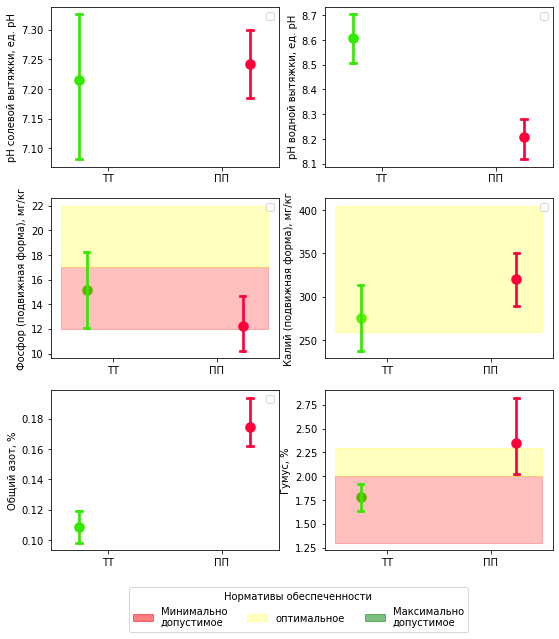

In [24]:
agrochem_prop = [
    "рН солевой вытяжки, ед. рН",
    "рН водной вытяжки, ед. рН", 
    "Фосфор (подвижная форма), мг/кг", 
    "Калий (подвижная форма), млн-1", 
    "Общий азот, %",
    'Гумус, %']
fig, ax  = plt.subplots(3,2, figsize = (9,10))
sns.pointplot(
    data = тальвеги,
    x = 'Тип обработки',
    y = "рН солевой вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Тип обработки',
    y = "рН водной вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Тип обработки',
    y = "Фосфор (подвижная форма), мг/кг", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,0])
ax[1,0].fill_between(x = [-0.5,1.5] , y1 = 12,y2 = 17, color='Red', alpha = 0.25)
ax[1,0].fill_between(x = [-0.5,1.5] , y1 = 17,y2 = 22, color='Yellow', alpha = 0.25)
ax[1,0].set_xlabel('')
ax[1,0].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Тип обработки',
    y = "Калий (подвижная форма), млн-1", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,1])
ax[1,1].fill_between(x = [-0.5,1.5] , y1 = 260,y2 = 405, color='Yellow', alpha = 0.25)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('Калий (подвижная форма), мг/кг')

ax[1,1].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Тип обработки',
    y = "Общий азот, %", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,0])
ax[2,0].set_xlabel('')
ax[2,0].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Тип обработки',
    y = 'Гумус, %', 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,1])
ax[2,1].fill_between(x = [-0.5,1.5] , y1 = 1.3,y2 = 2, color='Red', alpha = 0.25)
ax[2,1].fill_between(x = [-0.5,1.5] , y1 = 2,y2 = 2.3, color='Yellow', alpha = 0.25)
ax[2,1].set_xlabel('')
ax[2,1].legend([],[])


a = mpatches.Patch(color="Red", label= 'Минимально\nдопустимое',alpha=0.5)
b = mpatches.Patch(color="Yellow", label= "оптимальное",alpha=0.25)
c = mpatches.Patch(color="Green", label= 'Максимально\nдопустимое',alpha=0.5)

plt.legend(handles=[a,b,c], title='Нормативы обеспеченности',bbox_to_anchor=(0.65,-0.20),ncol = 3)

In [25]:
for ind, prop in enumerate(agrochem_prop):
    sample_list = []
    ab_test = pd.DataFrame()
    for value  in ['ПП','ТТ']:
        sample = тальвеги[тальвеги['Тип обработки'] == value][prop]
        sample_list.append(sample) 
    p_val = ANOVA(*sample_list)[1]
    local_df = pd.DataFrame({"свойство":prop, 'p-value' : p_val}, index = [ind])
    print(local_df)
    ab_test = ab_test.append(local_df)

                     свойство   p-value
0  рН солевой вытяжки, ед. рН  0.720497
                    свойство   p-value
1  рН водной вытяжки, ед. рН  0.000003
                          свойство   p-value
2  Фосфор (подвижная форма), мг/кг  0.160871
                         свойство   p-value
3  Калий (подвижная форма), млн-1  0.088319
        свойство   p-value
4  Общий азот, %  0.000002
   свойство   p-value
5  Гумус, %  0.027425
